Install the libraries

In [1]:
!pip install transformers==4.28.0

In [2]:
from collections import defaultdict
import gdown
import gzip
import json
import random
import pickle

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

In [3]:
#import the libraries for importing and dealing with data
import numpy as np
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#import libraries for processing
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re

In [6]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Load German Dataset and Clean it**

In [7]:
#load and read the training TEXT From file
germantrainingSet = pd.read_csv('drive/MyDrive/germanOriginal.txt', on_bad_lines='skip', sep=';', header=None)

In [8]:
#rename the column 2 to 'Tweet' and column 4 to 'Label
germantrainingSet=germantrainingSet.rename(columns={0: 'Tweet'})

In [9]:
germantrainingSet.head()

,Tweet
0,"@corinnamilborn Liebe Corinna, wir würden dich..."
1,@Martin28a Sie haben ja auch Recht. Unser Twee...
2,@ahrens_theo fröhlicher gruß aus der schönsten...
3,@dushanwegner Amis hätten alles und jeden gewä...
4,@spdde kein verläßlicher Verhandlungspartner. ...


In [10]:
germantrainingSet

,Tweet
0,"@corinnamilborn Liebe Corinna, wir würden dich..."
1,@Martin28a Sie haben ja auch Recht. Unser Twee...
2,@ahrens_theo fröhlicher gruß aus der schönsten...
3,@dushanwegner Amis hätten alles und jeden gewä...
4,@spdde kein verläßlicher Verhandlungspartner. ...
...,...
4806,@vadderland Deshalb sprach ich vom WENDEN 😂😂😂 ...
4807,"@GlasenappHenrik Zu Merkel fällt mir nur ein, ..."
4808,@KokoLores20 @krippmarie Ein richtiges Zeichen...
4809,"@Hartes_Geld ,Honecker‘Merkel macht uns zur ,D..."


In [11]:
def check_for_abuse(row):
    if row.endswith("ABUSE"):
        return 1
    else:
        return 0

In [12]:
germantrainingSet['Label'] = germantrainingSet['Tweet'].apply(check_for_abuse)

In [13]:
germantrainingSet['Tweet'] = germantrainingSet['Tweet'].apply(lambda x: ' '.join(x.split()[:-1]))

In [14]:
germantrainingSet['Tweet'] = germantrainingSet['Tweet'].str.replace('OTHER', '')
germantrainingSet['Tweet'] = germantrainingSet['Tweet'].str.replace('OFFENSE', '')

In [15]:
germantrainingSet

,Tweet,Label
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0
3,@dushanwegner Amis hätten alles und jeden gewä...,0
4,@spdde kein verläßlicher Verhandlungspartner. ...,0
...,...,...
4806,@vadderland Deshalb sprach ich vom WENDEN 😂😂😂 ...,0
4807,"@GlasenappHenrik Zu Merkel fällt mir nur ein, ...",0
4808,@KokoLores20 @krippmarie Ein richtiges Zeichen...,1
4809,"@Hartes_Geld ,Honecker‘Merkel macht uns zur ,D...",1


In [16]:
germantrainingSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4811 entries, 0 to 4810
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   4811 non-null   object
 1   Label   4811 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.3+ KB


In [17]:
count = (germantrainingSet['Label'] == 1).sum()

# The condition (df['Label'] == 1) checks for rows with value 1, and sum() counts the True values

print("Number of rows with value 1 in 'Label' column:", count)

Number of rows with value 1 in 'Label' column: 995


In [18]:
countZero = (germantrainingSet['Label'] == 0).sum()

# The condition (df['Label'] == 0) checks for rows with value 1, and sum() counts the True values

print("Number of rows with value 0 in 'Label' column:", countZero)

Number of rows with value 0 in 'Label' column: 3816


In [19]:
#function remove_urls cleans the Urls from the Tweets and put in a seperate column
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

germantrainingSet["tweet_without_url"] = germantrainingSet["Tweet"].apply(lambda text: remove_urls(text))

In [20]:
germantrainingSet.head()

,Tweet,Label,tweet_without_url
0,"@corinnamilborn Liebe Corinna, wir würden dich...",0,"@corinnamilborn Liebe Corinna, wir würden dich..."
1,@Martin28a Sie haben ja auch Recht. Unser Twee...,0,@Martin28a Sie haben ja auch Recht. Unser Twee...
2,@ahrens_theo fröhlicher gruß aus der schönsten...,0,@ahrens_theo fröhlicher gruß aus der schönsten...
3,@dushanwegner Amis hätten alles und jeden gewä...,0,@dushanwegner Amis hätten alles und jeden gewä...
4,@spdde kein verläßlicher Verhandlungspartner. ...,0,@spdde kein verläßlicher Verhandlungspartner. ...


**Load Spanish Dataset and Clean it**

In [21]:
#load and read the training TEXT From file
spanishtrainingSet = pd.read_csv('drive/MyDrive/spanishOriginal.txt', on_bad_lines='skip', sep=';', header=None)

In [22]:
spanishtrainingSet.head()

,0,1,2,3,4
0,id=828025263321657348,||,Ismael es egocentrico porque se vuelve loca si...,||,0
1,id=828025128797741057,||,..ya tardaba en salir quien pronunciase nombre...,||,0
2,id=828025087815274496,||,"(Esto no es un discurso político y razonado, o...",||,0
3,id=828025006626058241,||,"Muy despreciados,siiii,pero todos vestidos de ...",||,1
4,id=828024709761658880,||,marica explicame porque a veces no te entiendo...,||,1


In [23]:
#drop the columns not needed
spanishtrainingSet.drop(columns=0, inplace=True)
spanishtrainingSet.drop(columns=1, inplace=True)
spanishtrainingSet.drop(columns=3,inplace=True)

In [24]:
#rename the column 2 to 'Tweet' and column 4 to 'Label
spanishtrainingSet=spanishtrainingSet.rename(columns={2: 'Tweet'})
spanishtrainingSet=spanishtrainingSet.rename(columns={4: 'Label'})

**Remove all links**

In [25]:
#function remove_urls cleans the Urls from the Tweets and put in a seperate column
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

spanishtrainingSet["tweet_without_url"] = spanishtrainingSet["Tweet"].apply(lambda text: remove_urls(text))

In [26]:
spanishtrainingSet.head()

,Tweet,Label,tweet_without_url
0,Ismael es egocentrico porque se vuelve loca si...,0,Ismael es egocentrico porque se vuelve loca si...
1,..ya tardaba en salir quien pronunciase nombre...,0,..ya tardaba en salir quien pronunciase nombre...
2,"(Esto no es un discurso político y razonado, o...",0,"(Esto no es un discurso político y razonado, o..."
3,"Muy despreciados,siiii,pero todos vestidos de ...",1,"Muy despreciados,siiii,pero todos vestidos de ..."
4,marica explicame porque a veces no te entiendo...,1,marica explicame porque a veces no te entiendo...


**Load Italian Dataset and Clean it **

In [27]:
#load and read the training TEXT From file
italiantrainingSet = pd.read_csv('drive/MyDrive/italianOriginal.tsv', on_bad_lines='skip', sep='\t')

In [28]:
#drop the columns not needed
italiantrainingSet.drop(columns='id', inplace=True)
italiantrainingSet.drop(columns='stereotype', inplace=True)

In [29]:
#rename the column text to 'Tweet' and column hs to 'Label
italiantrainingSet=italiantrainingSet.rename(columns={'text ': 'Tweet'})
italiantrainingSet=italiantrainingSet.rename(columns={'hs': 'Label'})

In [30]:
#function remove_urls cleans the Urls from the Tweets and put in a seperate column
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

italiantrainingSet["tweet_without_url"] = italiantrainingSet["Tweet"].apply(lambda text: remove_urls(text))

In [31]:
italiantrainingSet.head()

,Tweet,Label,tweet_without_url
0,"È terrorismo anche questo, per mettere in uno ...",0,"È terrorismo anche questo, per mettere in uno ..."
1,@user @user infatti finché ci hanno guadagnato...,0,@user @user infatti finché ci hanno guadagnato...
2,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,"Corriere: Tangenti, Mafia Capitale dimenticata..."
3,"@user ad uno ad uno, perché quando i migranti ...",0,"@user ad uno ad uno, perché quando i migranti ..."
4,Il divertimento del giorno? Trovare i patrioti...,0,Il divertimento del giorno? Trovare i patrioti...


**Merge the Data**

In [32]:
germantrainingSet.shape

(4811, 3)

In [33]:
#drop the columns not needed
germantrainingSet.drop(columns='Tweet', inplace=True)
#germantrainingSet.drop(columns='tweet_w/o_url', inplace=True)
#germantrainingSet.drop(columns='tweet_lem', inplace=True)

In [34]:
germantrainingSet.head()

,Label,tweet_without_url
0,0,"@corinnamilborn Liebe Corinna, wir würden dich..."
1,0,@Martin28a Sie haben ja auch Recht. Unser Twee...
2,0,@ahrens_theo fröhlicher gruß aus der schönsten...
3,0,@dushanwegner Amis hätten alles und jeden gewä...
4,0,@spdde kein verläßlicher Verhandlungspartner. ...


In [35]:
#figure out the shape of spanish set
spanishtrainingSet.shape

(5851, 3)

In [36]:
#drop the columns not needed
spanishtrainingSet.drop(columns='Tweet', inplace=True)
#spanishtrainingSet.drop(columns='tweet_w/o_url', inplace=True)
#spanishtrainingSet.drop(columns='tweet_lem', inplace=True)

In [37]:
spanishtrainingSet.head()

,Label,tweet_without_url
0,0,Ismael es egocentrico porque se vuelve loca si...
1,0,..ya tardaba en salir quien pronunciase nombre...
2,0,"(Esto no es un discurso político y razonado, o..."
3,1,"Muy despreciados,siiii,pero todos vestidos de ..."
4,1,marica explicame porque a veces no te entiendo...


In [38]:
#figure out the shape of italian set
italiantrainingSet.shape

(6837, 3)

In [39]:
#drop the columns not needed
italiantrainingSet.drop(columns='Tweet', inplace=True)
#italiantrainingSet.drop(columns='tweet_w/o_url', inplace=True)
#italiantrainingSet.drop(columns='tweet_lem', inplace=True)

In [40]:
#rename the column 2 to 'Tweet' and column 4 to 'Label
italiantrainingSet=italiantrainingSet.rename(columns={1: 'tweet_without_url'})


In [41]:
italiantrainingSet.head()

,Label,tweet_without_url
0,0,"È terrorismo anche questo, per mettere in uno ..."
1,0,@user @user infatti finché ci hanno guadagnato...
2,0,"Corriere: Tangenti, Mafia Capitale dimenticata..."
3,0,"@user ad uno ad uno, perché quando i migranti ..."
4,0,Il divertimento del giorno? Trovare i patrioti...


In [42]:
germanspanish_merged = pd.merge(germantrainingSet, spanishtrainingSet, how="outer", on=["Label", "tweet_without_url"])

In [43]:
germanspanish_merged.shape

(10662, 2)

In [44]:
germanspanish_merged.head()

,Label,tweet_without_url
0,0,"@corinnamilborn Liebe Corinna, wir würden dich..."
1,0,@Martin28a Sie haben ja auch Recht. Unser Twee...
2,0,@ahrens_theo fröhlicher gruß aus der schönsten...
3,0,@dushanwegner Amis hätten alles und jeden gewä...
4,0,@spdde kein verläßlicher Verhandlungspartner. ...


In [45]:
print(germanspanish_merged)

       Label                                  tweet_without_url
0          0  @corinnamilborn Liebe Corinna, wir würden dich...
1          0  @Martin28a Sie haben ja auch Recht. Unser Twee...
2          0  @ahrens_theo fröhlicher gruß aus der schönsten...
3          0  @dushanwegner Amis hätten alles und jeden gewä...
4          0  @spdde kein verläßlicher Verhandlungspartner. ...
...      ...                                                ...
10657      0  Sea independentista o constitucionalista, la d...
10658      0  @Bernithedude Llave de gobierno de qué si hay ...
10659      0  @13Pardis @guenhwyvarblack Los carlinos son un...
10660      0  Aplausos en el partido de Colau cuando anuncia...
10661      0  @Rafa_Hernando La Constitución es independenti...

[10662 rows x 2 columns]


In [46]:
germanspanishitalian_merged = pd.merge(germanspanish_merged, italiantrainingSet, how="outer", on=["Label", "tweet_without_url"])

In [47]:
germanspanishitalian_merged.shape

(17499, 2)

In [48]:
print(germanspanishitalian_merged)

       Label                                  tweet_without_url
0          0  @corinnamilborn Liebe Corinna, wir würden dich...
1          0  @Martin28a Sie haben ja auch Recht. Unser Twee...
2          0  @ahrens_theo fröhlicher gruß aus der schönsten...
3          0  @dushanwegner Amis hätten alles und jeden gewä...
4          0  @spdde kein verläßlicher Verhandlungspartner. ...
...      ...                                                ...
17494      0  Gli stati nazionali devono essere pronti a rin...
17495      0  Il ministro dell'interno della Germania #Horst...
17496      0  #Salvini: In Italia troppi si sono montati la ...
17497      0  @user @user Chi giubila in buona fede non ha c...
17498      0  I giovani cristiani in #Etiopia sono indotti d...

[17499 rows x 2 columns]


In [49]:
germanspanishitalian_merged.head()

,Label,tweet_without_url
0,0,"@corinnamilborn Liebe Corinna, wir würden dich..."
1,0,@Martin28a Sie haben ja auch Recht. Unser Twee...
2,0,@ahrens_theo fröhlicher gruß aus der schönsten...
3,0,@dushanwegner Amis hätten alles und jeden gewä...
4,0,@spdde kein verläßlicher Verhandlungspartner. ...


Rename Label to 'label'

In [50]:
germanspanishitalian_merged = germanspanishitalian_merged.rename(columns={'Label': 'label'})

In [51]:
#print(germanspanishitalian_merged["tweetwithoutstop"])

In [52]:
#print(germanspanishitalian_merged['label'])

In [53]:
X = germanspanishitalian_merged["tweet_without_url"].values.tolist()

In [54]:
y = germanspanishitalian_merged['label'].values.tolist()

**Split the text**

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 0)

In [56]:
train_texts = X_train
train_labels = y_train

test_texts = X_test
test_labels = y_test

In [57]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(13999, 13999, 3500, 3500)

In [58]:
train_labels[0], train_texts[0]

(1,
 '@user Possibile che si debba passare ai fatti per far capire a tutti che ci siamo stufati di essere presi per il culo e per il portafogli? Io non voglio dare un euro a migranti, clandestini, rom e feccia varia. ')

In [59]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [60]:
#import svm model and metrics
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [61]:

#SVM BASE LINE

model = SVC(kernel='linear', gamma='auto').fit(X_train, train_labels)
predictions = model.predict(X_test)

In [62]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2436
           1       0.71      0.53      0.61      1064

    accuracy                           0.79      3500
   macro avg       0.76      0.72      0.73      3500
weighted avg       0.78      0.79      0.78      3500



In [63]:
#calculate F1 score
from sklearn.metrics import f1_score
f1_score(test_labels, predictions)

0.6088362068965517

In [64]:
from sklearn.metrics import matthews_corrcoef
#calculate Matthews correlation coefficient
matthews_corrcoef(test_labels, predictions)

0.4813129456018161

In [65]:
# This is the name of the BERT model that we want to use.
model_name = 'xlm-roberta-base'

# This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'Masterxlmroberta-saved-model'

In [66]:
from transformers import AutoTokenizer, XLMRobertaModel
from transformers import XLMRobertaForSequenceClassification
from transformers import BertForSequenceClassification, BertTokenizer
#tokenizer = BertTokenizer.from_pretrained("xlm-roberta-base")
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
#tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # The model_name needs to match our pre-trained model.

In [67]:
train_labels


[1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


In [68]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [69]:
label2id.keys()

dict_keys([0, 1])

In [70]:
id2label.keys()

dict_keys([0, 1])

In [71]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [72]:
set(train_labels_encoded)

{0, 1}

In [73]:
set(test_labels_encoded)

{0, 1}

In [74]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [75]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [76]:
# The model_name needs to match the name used for the tokenizer above.
#model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [77]:
#!pip install --upgrade accelerate

In [78]:
training_args = TrainingArguments(
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=2e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

In [79]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [80]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function
)

In [81]:
torch.cuda.empty_cache()

In [82]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,0.661500,0.610429,0.696000
200,0.608600,0.592379,0.708571
300,0.574400,0.628428,0.745429
400,0.512600,0.544443,0.752857
500,0.575800,0.745172,0.696857
600,0.640800,0.603106,0.696000
700,0.596100,0.527888,0.764286
800,0.575900,0.473652,0.776857
900,0.517400,0.480702,0.790857
1000,0.511800,0.509506,0.745143


TrainOutput(global_step=3500, training_loss=0.47113734327043805, metrics={'train_runtime': 1562.4191, 'train_samples_per_second': 17.92, 'train_steps_per_second': 2.24, 'total_flos': 7366583327969280.0, 'train_loss': 0.47113734327043805, 'epoch': 2.0})

In [83]:
trainer.save_model(cached_model_directory_name)

In [84]:
trainer.evaluate()

{'eval_loss': 0.4449751079082489,
 'eval_accuracy': 0.8251428571428572,
 'eval_runtime': 13.1338,
 'eval_samples_per_second': 266.488,
 'eval_steps_per_second': 13.324,
 'epoch': 2.0}

In [85]:
predicted_results = trainer.predict(test_dataset)

In [86]:
predicted_results.predictions.shape

(3500, 2)

In [87]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [88]:
len(predicted_labels)

3500

In [89]:
print(classification_report(test_labels,
                            predicted_labels))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88      2436
           1       0.74      0.65      0.69      1064

    accuracy                           0.83      3500
   macro avg       0.80      0.78      0.79      3500
weighted avg       0.82      0.83      0.82      3500



In [90]:
#calculate F1 score
from sklearn.metrics import f1_score
f1_score(test_labels, predicted_labels)

0.6930792377131395

In [91]:
from sklearn.metrics import matthews_corrcoef
#calculate Matthews correlation coefficient
matthews_corrcoef(test_labels, predicted_labels)

0.5741279085045286

In [92]:
from sklearn.metrics import confusion_matrix

In [93]:
cm = confusion_matrix(test_labels, predicted_labels)

In [94]:
print(cm)

[[2197  239]
 [ 373  691]]


<Axes: >

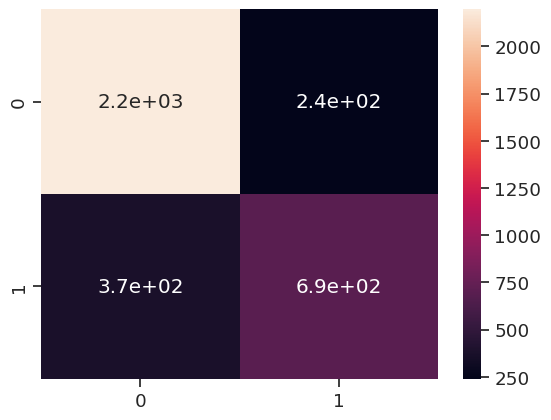

In [95]:
import seaborn as sns
sns.heatmap(cm, annot=True)

<Axes: >

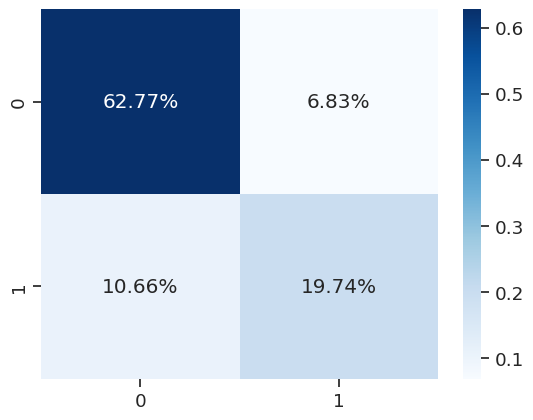

In [96]:
sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues')

In [97]:
heatlabels = ['True Neg','False Pos','False Neg','True Pos']


In [98]:
heatlabels = np.asarray(heatlabels).reshape(2,2)


<Axes: >

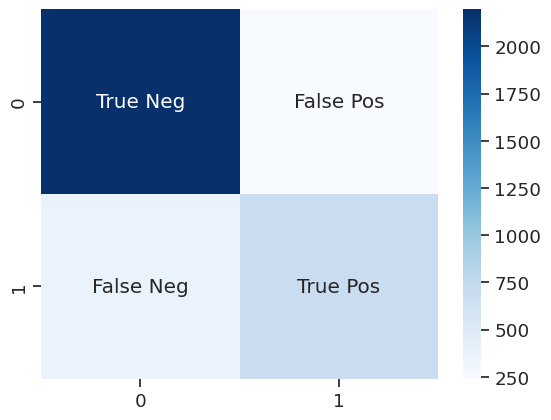

In [99]:
sns.heatmap(cm, annot=heatlabels, fmt='', cmap='Blues')

In [100]:
group_names = ['True Neg','False Pos','False Neg','True Pos']


In [101]:
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]


In [102]:
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

In [103]:
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

In [104]:
labels = np.asarray(labels).reshape(2,2)

<Axes: >

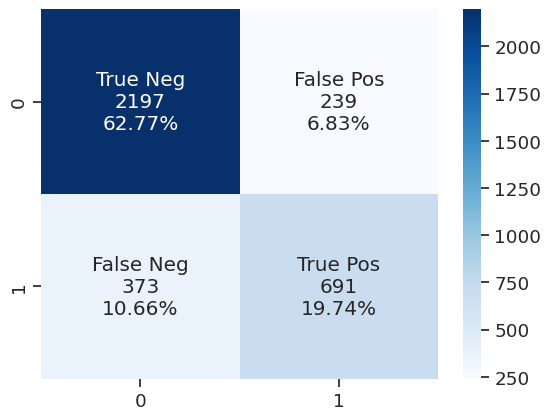

In [105]:
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

#let s go further in the analysis: Let s print some correct classifications

In [106]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('Hatespeech Tweet:', _text[:100], '...')
    print()

LABEL: 1
Hatespeech Tweet: In circoscrizione x un documento a Roma  ! più extracomunitari  che Italiani ho  l'impressione di es ...

LABEL: 0
Hatespeech Tweet: Divieti sull?immigrazione e proteste in aeroporto: anche i nonluoghi hanno un?anima URL URL  ...

LABEL: 0
Hatespeech Tweet: @Sammy_aus_Cux Wenn du meinst hab besseres vor als mich über Geschlechter zu unterhalten schönen tag ...

LABEL: 0
Hatespeech Tweet: Si leéis el foro veréis q hay muchos fascistas apoyando a Errejón seguro q se han inscrito para lo m ...

LABEL: 1
Hatespeech Tweet: @shlomosapiens @KrahMax Ich will nicht das es Kriminellen Flüchtlingen Deserteuren und Feiglingen hi ...

LABEL: 0
Hatespeech Tweet: Treviso, spara e ferisce alla testa un ladro nomade: ora il vigilante è accusato di tentato omicidio ...

LABEL: 0
Hatespeech Tweet: @Zukunftskinder @TOnline_TopNews @oezoguz Einfach mal Fresse halten! 😛  ...

LABEL: 0
Hatespeech Tweet: #terrorismo Fabrizia per la Germania è vittima della strada URL URL rt IlCapolu

#and now some miscorrect classifications

In [107]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    #print('Original TweeT:', _text[:100], '...')
    print('Original Tweet:', _text)
    print()

TRUE LABEL: 0
PREDICTED LABEL: 1
Original Tweet: L’Italia è un paese così RAZZISTA che permette ai cosiddetti #migranti di vivere in hotel, mentre i poveri italiani, dormono sotto i ponti... 

TRUE LABEL: 1
PREDICTED LABEL: 0
Original Tweet: Me quiero rapar el pelo pero si lo hago no me voy a poder poner las martens sin parecer un puto nazi :(

TRUE LABEL: 1
PREDICTED LABEL: 0
Original Tweet: Il "povero profugo inerme" ucciso a Fermo faceva parte della mafia nigeriana? | IL PRIMATO NAZIONALE URL via @user 

